# Sentiment Analysis for Missing Data And Recommendation System for Movies Dataset

## Source:

https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset

##### Problematic
In Movie Reviewing webpages, anyone can leave a review for a recently watched movie, or for any movie. Others users can also see other's peoples comments and reviews of any movie, and decide wether they will watch it or not in the future. In this webpages, users can leave a rating score, a written critic or even both of them. Having a rating score makes things so much easier for others users and for the websites to categorize the movies and also for movies platforms to recommend other movies to the users based on the rating score that they provided. 

In this notebook I have a Dataset form `Rotten Tomatoes` and the objective of this notebook is to check how many users provided a written critic but didn't rated the movie with a numeric score. Then I will use Sentiment Analysis to get a weighted score and impute it on the missing values. 

After having the scores, I will make two recommender systems, one Collaborative Recommender System using cosine symilarity and K Nearest Neighbors and one Content Based Recommender System using TFID for comparing the Movie Information aka Synopsis and Genres. 

## Importing Libraries

In [1]:
#Loading dataset
import pandas as pd
import numpy as np
from tqdm import tqdm

#graphing
import seaborn as sns
import matplotlib.pyplot as plt

#Sentiment Analysis from hugging face 
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

#Recomendation Systems
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer

## Loading the datasets
We have two datasets the first one are the reviews, it has both written and review score, but just having a quick look at the head, we can notice that there are some reviews without a numeric score but with written reviews.

In [2]:
reviews = pd.read_csv('rotten_tomatoes_critic_reviews.csv')
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [3]:
rows, columns = reviews.shape
print('The Dataset has',rows,'rows and ',columns,'columns.' )

The Dataset has 1130017 rows and  8 columns.


The second dataset is the movies dataset, it contains the titles, synopsis and other meta data. We are just interested in the title of the movie, the genres, the synopsis and the Rotten Tomatoes link, being that it is a unique key that we will be using for merging the two data sets.

In [4]:
movies = pd.read_csv('rotten_tomatoes_movies.csv')
movies.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


# Understanding my data

I will do a few graphs to get some insights on my data

<AxesSubplot:xlabel='review_type', ylabel='count'>

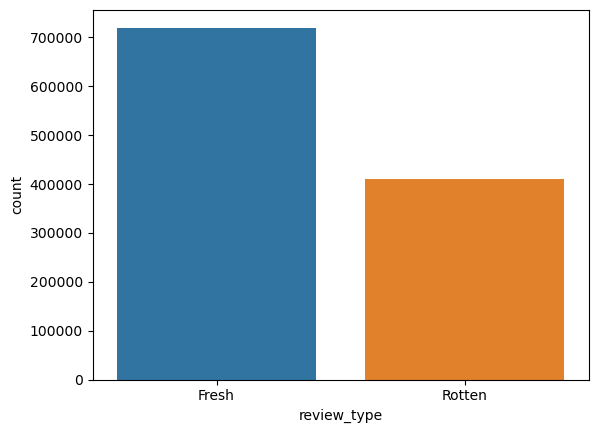

In [5]:
sns.countplot(data=reviews, x='review_type')

<AxesSubplot:xlabel='top_critic', ylabel='count'>

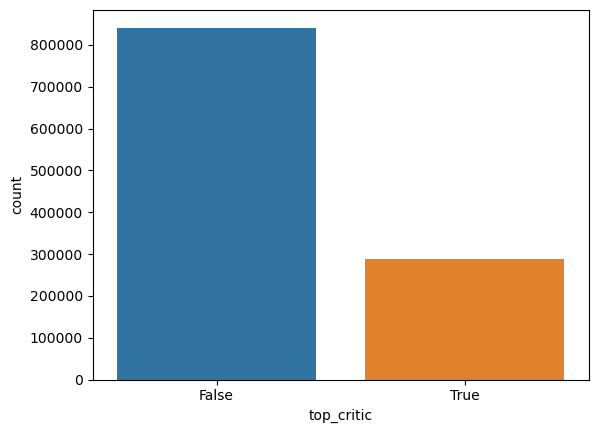

In [6]:
sns.countplot(data=reviews, x='top_critic')

<AxesSubplot:xlabel='content_rating', ylabel='count'>

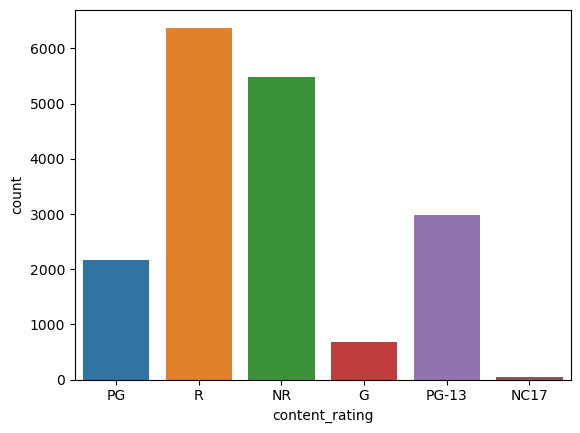

In [7]:
sns.countplot(data=movies, x='content_rating')

In [8]:
print('We have',reviews['review_score'].isnull().sum(),'missing values for review scores.')

We have 305936 missing values for review scores.


In [9]:
mask = (reviews['review_score'].isnull()) & (reviews['review_content'].notnull())

In [10]:
reviews = reviews.loc[mask]

In [11]:
print('We have',len(reviews), 'missing values for review scores that have a Written review')

We have 305502 missing values for review scores that have a Written review


## Insights
- The majority of the movies are R rated, which are movies considered for Adults. 
- Most of our movies are are Fresh, meaning that they have a good Review.
- Most of the critics are not considered as Top Critics, according to Rotten Tomatoes, a Top Critic is someone who is considered as a Proffesional Reviewer.
- We have a good amount of Rows for working in our task, even after filtering I will need to sample a few of them so my computer can run it.

## Merging Datasets
Now we will select just the columns that we want to use for imputing the Missing Values for Scores and for the Recommendation System. Additionally for making the data set smaller so my computer is able to run the code I will just select the entries of the critics that have made more than 1000 reviews and then select a sample of 500 hundred entries. At the end we will have a new dataframe with 500 rows. 

In [12]:
reviews_counts = reviews['critic_name'].value_counts()

min_reviews = 1000

#Changing original Dataset
reviews = reviews[reviews['critic_name'].isin(reviews_counts[reviews_counts > min_reviews].index)]

reviews

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
16,m/0814255,MaryAnn Johanson,False,Flick Filosopher,Fresh,NaN,2010-02-11,"[P]erfectly inoffensive, occasionally clever....."
44,m/0814255,Peter Debruge,True,Variety,Fresh,NaN,2010-02-11,Action movies of this scale often start off st...
...,...,...,...,...,...,...,...,...
1129881,m/zootopia,Louise Keller,False,Urban Cinefile,Fresh,NaN,2016-04-03,It's a gorgeous film beautifully executed with...
1129897,m/zootopia,Felix Vasquez Jr.,False,Cinema Crazed,Fresh,NaN,2016-06-19,Another stellar Disney film that begs for a se...
1129910,m/zootopia,Robert Denerstein,False,Movie Habit,Fresh,NaN,2016-12-12,"Directors Byron Howard, Rich Moore and Jared B..."
1129920,m/zootopia,Stephanie Zacharek,True,TIME Magazine,Fresh,NaN,2016-12-30,"There are enough under-the-radar subtleties, r..."


**Showing users that have given more than 1000 reviews**

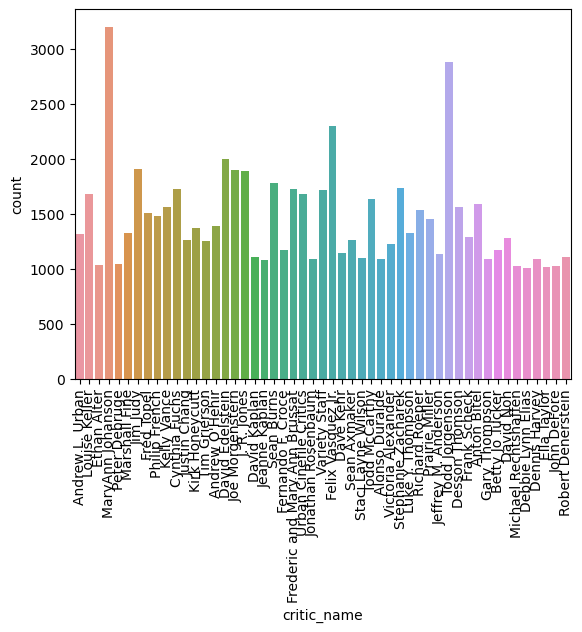

In [13]:
fig = sns.countplot(data=reviews, x='critic_name')
fig.tick_params(axis='x', labelrotation=90)

At this point, the Reviews dataset has just the entries of users that have provided more than 1000 reviews. Now we will merge the reviews and movies data set on the Rotten Tomatoes link column, so we have the respective movies.

In [14]:
movies = movies[['rotten_tomatoes_link', 'movie_title', 'genres', 'movie_info', 'actors']]
ratings = reviews[['rotten_tomatoes_link','critic_name', 'review_score', 'review_content']]
merged_df = pd.merge(movies,ratings,how='outer', on='rotten_tomatoes_link')


In [15]:
merged_df.dropna(subset=['review_content'], inplace=True)
merged_df = merged_df.sample(500)

In [16]:
merged_df.reset_index(inplace=True)
merged_df.head(2)

,index,rotten_tomatoes_link,movie_title,genres,movie_info,actors,critic_name,review_score,review_content
0,48088,m/quiz_show,Quiz Show,Drama,Queens-born Herbie Stempel (John Turturro) bec...,"John Turturro, Ralph Fiennes, Rob Morrow, Paul...",Desson Thomson,NaN,Artfully constructed and beautifully shot.
1,23162,m/everything_is_illuminated,Everything is Illuminated,"Action & Adventure, Comedy, Drama",A young Jewish-American man obsessed with his ...,"Elijah Wood, Eugene Hutz, Laryssa Lauret, Olek...",Gary Thompson,NaN,Schreiber has managed ... to preserve key them...


## Sentiment Analysis using Hugging Face Library (ROBERTA)
We will run our sentiment analysis on the Written Reviews to assign a value on the missing score value entries so we have more data for the recommendation system.

**Notes:** 
- I will be using a sentiment analysis model that has been pre-trained with more than 124M tweets. It is available in Huggings Face library. I use it because it can make the sentiment analysis more accurately. It uses pytorch library.

- In my Notebook it pops an Error which seems to be common among users, I think that this is because I ran prevously another version of the Model. It doesn't seem to be affecting the results, since I consider them accurate. 



In [17]:
#Creating the Model
ROBERTA = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(ROBERTA)
model = AutoModelForSequenceClassification.from_pretrained(ROBERTA)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Making the sentiment analysis function that will be applied on each row of the Dataframe

This is how it works: 
1. It tokenizes the text automatically and returns an encoded text in Pytorch Tensors
2. Then it runs The ROBERTA Model on the encoded or TOKENIZED text.
3. It makes the sentiment analysis and stores it on a dictionary

**Notes:**
I included a try and except block to check when it encounters no strings on the cell. 

In [18]:
def sentiment_analysis(written_review):
    try:
        encoded_text = tokenizer(written_review, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        scores_dict = {'negativ' : scores[0],'neutral' : scores[1],'positive': scores[2]}
        return scores_dict
    except ValueError:
        print(f'Broke for: {written_review}')


This is another function that will compute a Score ranging from 0 to 5 so I can apply it on the Dataframe. 1 to 5 is the range of the scoring in Rotting Tomatoes Website.

I use a personal heuristic value for weighting individually each Negative, neutral and Positive score.

In [19]:
def get_score(scores_dict):
    try:
        weighted_score = (scores_dict['negativ'] * 1 +
                      scores_dict['neutral'] * 3 +
                      scores_dict['positive'] * 5)
        return weighted_score
    except TypeError:
        print(scores_dict)



## Example 1: Good Review

In [20]:
for i in merged_df['review_content']:
    analysis = sentiment_analysis(i)
    score = get_score(analysis)
    if score > 4.7:
        example = i
        
        print('Example Review:',example)
        print(analysis)
        print('Weighted Score:',score)
        break

Example Review: Artfully constructed and beautifully shot.
{'negativ': 0.021389445, 'neutral': 0.055266973, 'positive': 0.9233436}
Weighted Score: 4.803908357396722


## Example 2: Neutral Review

In [21]:
for i in merged_df['review_content']:
    analysis = sentiment_analysis(i)
    score = get_score(analysis)
    if score > 2.5 and score < 3:
        example = i
        print('Example Review:',example)
        print(analysis)
        print('Weighted Score:',score)
        break

Example Review: The filmmakers go to great lengths to create a sense of authenticity, to a fault. We are left to assume a lot about who is what and where they fit in
{'negativ': 0.27275234, 'neutral': 0.6729768, 'positive': 0.05427084}
Weighted Score: 2.5630369260907173


## Example 3: Bad Review

In [22]:
for i in merged_df['review_content']:
    analysis = sentiment_analysis(i)
    score = get_score(analysis)
    if score < 1.5:
        example = i
        print('Example Review:',example)
        print(analysis)
        print('Weighted Score:',score)
        break

Example Review: A mean-spirited, trashy and intermittently funny film.
{'negativ': 0.9004987, 'neutral': 0.08925613, 'positive': 0.010245198}
Weighted Score: 1.2194930706173182


### Imputing the Artificial  Review Score to each movie
(Slow but works)

In [23]:
analysis = merged_df['review_content'].apply(sentiment_analysis)
scores = analysis.apply(get_score)
merged_df['review_score'] = scores

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:


100%|█████████████████████████████████████| 500/500 [00:00<00:00, 735069.05it/s]

	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
merged_df

,index,rotten_tomatoes_link,movie_title,genres,movie_info,actors,critic_name,review_score,review_content
0,48088,m/quiz_show,Quiz Show,Drama,Queens-born Herbie Stempel (John Turturro) bec...,"John Turturro, Ralph Fiennes, Rob Morrow, Paul...",Desson Thomson,4.803908,Artfully constructed and beautifully shot.
1,23162,m/everything_is_illuminated,Everything is Illuminated,"Action & Adventure, Comedy, Drama",A young Jewish-American man obsessed with his ...,"Elijah Wood, Eugene Hutz, Laryssa Lauret, Olek...",Gary Thompson,3.404576,Schreiber has managed ... to preserve key them...
2,73,m/10002673-prowler,The Prowler (Cost of Living ),"Drama, Mystery & Suspense",After being frightened by a peeping Tom at her...,"Van Heflin, Evelyn Keyes, Katherine Warren, Jo...",Jeffrey M. Anderson,2.351684,A down and dirty masterpiece.
3,15617,m/call_me_by_your_name,Call Me by Your Name,"Drama, Romance","It's the summer of 1983, and precocious 17-yea...","Armie Hammer, Timothée Chalamet, Michael Stuhl...",Kelly Vance,3.293005,What distinguish it from the competition are t...
4,17907,m/colour-me-kubrick,Color Me Kubrick,"Comedy, Drama",Audacious con man Alan Conway (John Malkovich)...,"John Malkovich, Tom Allen, Scott Baker, Nick B...",Andrew O'Hehir,1.219493,"A mean-spirited, trashy and intermittently fun..."
...,...,...,...,...,...,...,...,...,...
495,433,m/10008703-rails_and_ties,Rails & Ties,Drama,Engineer Tom Stark (Kevin Bacon) kills a suici...,"Kevin Bacon, Marcia Gay Harden, Miles Heizer, ...",Michael Rechtshaffen,1.801313,This directorial debut by Clint's daughter get...
496,60233,m/star_trek_beyond,Star Trek Beyond,"Action & Adventure, Drama, Science Fiction & F...",A surprise attack in outer space forces the En...,"Chris Pine, Zachary Quinto, Anton Yelchin, Joh...",Jim Judy,4.699859,It's an entertaining diversion featuring chara...
497,4448,m/1158195-marie_antoinette,Marie Antoinette,"Documentary, Drama",An Austrian teenager (Kirsten Dunst) marries t...,"Kirsten Dunst, Jason Schwartzman, Judy Davis, ...",Kirk Honeycutt,2.093898,The movie slices through the cobwebs of histor...
498,73114,m/trucker,Trucker,Drama,Loner Diane Ford (Michelle Monaghan) is a truc...,"Michelle Monaghan, Nathan Fillion, Benjamin Br...",Betty Jo Tucker,4.820153,Who knew Michelle Monaghan could pull-off one ...


Now we have all the rows from `Review Score`filled in with the rating that we got using SENTIMENT ANALYSIS.

### Next Step: Build Recommendation System

First we want to have a Matrix with the title of the Movie and the different users with the assign Artificial Rating as values.

In [25]:
users_df = merged_df.pivot_table(values='review_score', index='movie_title', columns='critic_name')
users_df

critic_name,Alonso Duralde,Andrew L. Urban,Andrew O'Hehir,Anton Bitel,Betty Jo Tucker,Cynthia Fuchs,Dave Kehr,David Edelstein,David Kaplan,David Noh,...,Sean Axmaker,Sean Burns,Staci Layne Wilson,Stephanie Zacharek,Tim Grierson,Todd Jorgenson,Todd McCarthy,Urban Cinefile Critics,Variety Staff,Victoria Alexander
movie_title,,,,,,,,,,,,,,,,,,,,,
17 Again,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.006244,NaN,NaN,NaN,NaN,NaN,NaN
1917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.829435,NaN,NaN,NaN,NaN,NaN,NaN
22 July,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.958508,NaN,NaN,NaN,NaN,NaN
45 Years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.823392,NaN,NaN,NaN,NaN
6 Souls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.762104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Won't You Be My Neighbor?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wonderful Town,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
You Will Be My Son,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I am using K Neighrest Neighbors algorithm with the cosine metric to get the cosine distances, with the cosdine distances we will determine the similarity of each datapoint.

In [26]:
users_df = users_df.fillna(0)
movies_matrix = csr_matrix(users_df.values)

model_knn = NearestNeighbors(metric = 'cosine')
model_knn.fit(movies_matrix)

NearestNeighbors(metric='cosine')

In [27]:
def collaborative_recommendation(movie):
    print('Movie Index: ',movie)
    distances, indices = model_knn.kneighbors(users_df.iloc[movie,:].values.reshape(1, -1), n_neighbors = 6)

    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for Movie', str(users_df.index[random_movie]),':\n')
        else:
            print(str(i), ': ', str(users_df.index[indices.flatten()[i]]),', with distance of ' ,str(distances.flatten()[i]))


#### Recommendation for a Random Movie based on other users ratings

In [45]:
random_movie = np.random.choice(users_df.shape[0])
collaborative_recommendation(random_movie)


Movie Index:  160
Recommendations for Movie James VS His Future Self :

1 :  The Wolfpack , with distance of  0.0
2 :  Demon House , with distance of  0.0
3 :  Stuber , with distance of  0.0
4 :  The Night Before , with distance of  0.0
5 :  Slow West , with distance of  0.0


# Building Content Based Recommendation System with TFIDF

## Text Preprocessing
First we get the essential columns needed for this task,  we just need the Movie Title, the Genres and the Information of the movie

In [29]:
movies_details = merged_df[['movie_title','genres','movie_info']]
movies_details.head(2)

,movie_title,genres,movie_info
0,Quiz Show,Drama,Queens-born Herbie Stempel (John Turturro) bec...
1,Everything is Illuminated,"Action & Adventure, Comedy, Drama",A young Jewish-American man obsessed with his ...


Here I am creating a new DataFrame with called movie_details which I'll use for imputing the Processed text after the following steps:
1. Tokenization
2. Removing Stop Words
3. Stemming
4. Lemmatization

In [30]:
movies_details.insert(2,'Preprocessed_Genres', np.nan)
movies_details.insert(4,'Preprocessed_Info', np.nan)
movies_details.drop_duplicates(subset=['movie_title'], keep='first')
movies_details.head(2)

,movie_title,genres,Preprocessed_Genres,movie_info,Preprocessed_Info
0,Quiz Show,Drama,NaN,Queens-born Herbie Stempel (John Turturro) bec...,NaN
1,Everything is Illuminated,"Action & Adventure, Comedy, Drama",NaN,A young Jewish-American man obsessed with his ...,NaN


In [31]:
movies_details = movies_details.copy()
movies_details['genres'] = movies_details['genres'].astype(str)
movies_details['movie_info'] = movies_details['movie_info'].astype(str)

def preprocess_text(text):
    
    text = text.lower()
    #Tokenize
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
            
    #Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
            
    #Lemmatize
            
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
        
    processed_text = ' '.join(lemmatized_words)
    return(processed_text)

processed_genre = movies_details['genres'].apply(preprocess_text)
movies_details = movies_details.copy()
movies_details['Preprocessed_Genres'] = processed_genre


processed_info = movies_details['movie_info'].apply(preprocess_text)
movies_details = movies_details.copy()
movies_details['Preprocessed_Info'] = processed_info

#### Results for Processed Text
Here we have the Processed text for both Genres and Information. 

In [32]:
movies_details.set_index('movie_title', inplace=True)
movies_details.drop_duplicates(inplace=True)
movies_details.head(2)

,genres,Preprocessed_Genres,movie_info,Preprocessed_Info
movie_title,,,,
Quiz Show,Drama,drama,Queens-born Herbie Stempel (John Turturro) bec...,queens-born herbi stempel ( john turturro ) be...
Everything is Illuminated,"Action & Adventure, Comedy, Drama","action & adventur , comedi , drama",A young Jewish-American man obsessed with his ...,"young jewish-american man ob famili histori , ..."


## Recommendation Based On the Plot
Here I will apply TFIDF on the preprocessed text and then I will check the cosine similarities.

In [33]:
tfidf = TfidfVectorizer(ngram_range= (1, 3)) 
tfidf_info = tfidf.fit_transform((movies_details["Preprocessed_Info"])) 

cos_sim_info = cosine_similarity(tfidf_info, tfidf_info)
indices = pd.Series(movies_details.index)

#### Building Content Based Recommendation Function

Here I create a function that will get the top 5 Movies based on the highest cosine similarity scores. 
After Building the Function I call it on a Random Movie using the TFIDF for INFO

In [34]:
#SELECTING A RANDOM MOVIE
random_row=movies_details.sample().drop(columns=['Preprocessed_Info','Preprocessed_Genres'])
random_row

,genres,movie_info
movie_title,,
The King's Speech,Drama,England's Prince Albert (Colin Firth) must asc...


In [35]:
def tfidf_recommendation(title, cosine_sim):

    recommended_movies = []
    genres = []
    info = []
    
    #Getting top 5 Movies 
    index = indices[indices == title].index[0]
    sim_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False)
    top = list(sim_scores.iloc[1:6].index)
    
    #Putting the details of each movie in the empty lists
    for i in top:
        recommended_movies.append(list(movies_details.index)[i])
        info.append(list(movies_details.movie_info)[i])
        genres.append(list(movies_details.genres)[i])
        
        
    #Output
    pd.set_option('display.max_colwidth', None)
    print(' SELECTED MOVIE')
    display(random_row)
    print('TOP 5 RECOMMENDATIONS')

    return pd.DataFrame({'Recommended Movies ': recommended_movies,
                         'Genres': genres,
                         'Info': info})
    

tfidf_recommendation(random_row.index[0], cos_sim_info)


 SELECTED MOVIE


,genres,movie_info
movie_title,,
The King's Speech,Drama,"England's Prince Albert (Colin Firth) must ascend the throne as King George VI, but he has a speech impediment. Knowing that the country needs her husband to be able to communicate effectively, Elizabeth (Helena Bonham Carter) hires Lionel Logue (Geoffrey Rush), an Australian actor and speech therapist, to help him overcome his stammer. An extraordinary friendship develops between the two men, as Logue uses unconventional means to teach the monarch how to speak with confidence."


TOP 5 RECOMMENDATIONS


,Recommended Movies,Genres,Info
0,The Young Victoria,Drama,"As the only legitimate heir of England's King William, teenage Victoria (Emily Blunt) gets caught up in the political machinations of her own family. Victoria's mother (Miranda Richardson) wants her to sign a regency order, while her Belgian uncle schemes to arrange a marriage between the future monarch and Prince Albert (Rupert Friend), the man who will become the love of her life."
1,The Intouchables,"Art House & International, Comedy, Drama, Special Interest","An unlikely friendship develops between a wealthy quadriplegic (François Cluzet) and his caretaker (Omar Sy), just released from prison."
2,The Artist,"Comedy, Drama, Romance","In the 1920s, actor George Valentin (Jean Dujardin) is a bona fide matinee idol with many adoring fans. While working on his latest film, George finds himself falling in love with an ingenue named Peppy Miller (Bérénice Bejo) and, what's more, it seems Peppy feels the same way. But George is reluctant to cheat on his wife with the beautiful young actress. The growing popularity of sound in movies further separates the potential lovers, as George's career begins to fade while Peppy's star rises."
3,Pirates of the Caribbean: On Stranger Tides,"Action & Adventure, Comedy, Science Fiction & Fantasy","The checkered past of Capt. Jack Sparrow (Johnny Depp) catches up to him when he encounters Angelica (Penélope Cruz), a beautiful pirate that Jack once loved then left. Angelica forces him to accompany her to the Queen Anne's Revenge, the ship of the notorious Blackbeard (Ian McShane). Accompanied by a zombie crew, the trio sets sail to find the legendary Fountain of Youth. However, Jack's rival, Barbossa (Geoffrey Rush), also seeks the fountain, as does a ship from Spain."
4,The Descendants,"Comedy, Drama","Native islander Matt King (George Clooney) lives with his family in Hawaii. Their world shatters when a tragic accident leaves his wife in a coma. Not only must Matt struggle with the stipulation in his wife's will that she be allowed to die with dignity, but he also faces pressure from relatives to sell their family's enormous land trust. Angry and terrified at the same time, Matt tries to be a good father to his young daughters, as they too try to cope with their mother's possible death."


## Recommendation Based on Genres
Here I do the same steps like before, but I use TFIDF on the preprocessed Genre column and call the recommendation function using the same Random Movie and the cosine similarities for Genres as parameters.

In [36]:
tfidf = TfidfVectorizer() 
tfidf_genres = tfidf.fit_transform((movies_details["Preprocessed_Genres"])) 

cos_sim_gen = cosine_similarity(tfidf_genres, tfidf_genres)
indices = pd.Series(movies_details.index)

tfidf_recommendation(random_row.index[0],cos_sim_gen)


 SELECTED MOVIE


,genres,movie_info
movie_title,,
The King's Speech,Drama,"England's Prince Albert (Colin Firth) must ascend the throne as King George VI, but he has a speech impediment. Knowing that the country needs her husband to be able to communicate effectively, Elizabeth (Helena Bonham Carter) hires Lionel Logue (Geoffrey Rush), an Australian actor and speech therapist, to help him overcome his stammer. An extraordinary friendship develops between the two men, as Logue uses unconventional means to teach the monarch how to speak with confidence."


TOP 5 RECOMMENDATIONS


,Recommended Movies,Genres,Info
0,Capital,Drama,The CEO of a giant investment bank in Europe tries to cling to power when an American hedge fund tries to buy the company.
1,Roma,Drama,"Cleo is one of two domestic workers who help Antonio and Sofía take care of their four children in 1970s Mexico City. Complications soon arise when Antonio suddenly runs away with his mistress and Cleo finds out that she's pregnant. When Sofía decides to take the kids on vacation, she invites Cleo for a much-needed getaway to clear her mind and bond with the family."
2,Me Before You,Drama,"Young and quirky Louisa ""Lou"" Clark (Emilia Clarke) moves from one job to the next to help her family make ends meet. Her cheerful attitude is put to the test when she becomes a caregiver for Will Traynor (Sam Claflin), a wealthy young banker left paralyzed from an accident two years earlier. Will's cynical outlook starts to change when Louisa shows him that life is worth living. As their bond deepens, their lives and hearts change in ways neither one could have imagined."
3,Beyond the Lights,Drama,"Though she's been groomed for stardom all her life by an overbearing mother (Minnie Driver), singer Noni (Gugu Mbatha-Raw) is having trouble dealing with her success. Feeling unable to cope any longer, Noni tries to kill herself, but luckily Kaz (Nate Parker), the police officer assigned to be her bodyguard, thwarts her suicide attempt. Noni and Kaz feel an instant attraction, but those in their orbit oppose the romance for fear the pair will stray from the course planned out for both of them."
4,Miss Potter,Drama,"Beatrix Potter (Renée Zellweger) overcomes many obstacles in her quest to become a writer, including a domineering mother and the chauvinism prevalent in Victorian England. She falls in love with her publisher, Norman Warne (Ewan McGregor), and his marriage proposal and a subsequent tragedy change her life forever."


# Conclussions

For quick Recap what I did in this notebook was:

### Part 1: Sentiment Analysis and Collaborative Recommender System

1. Getting a Raw dataset from Kaggle, the dataset was retrieved from Rotten Tomatoes website. 
2. After doing some exploration on the Data we encountered many entries that didn't have a numerical Review Score: I tackled this problem using sentiment analysis to impute missing values. 
3. Once I had an Artificial Score I made a Collaborative Recommender System using the cosine distances with KNearestNeighbors. 

### Part 2: Text Preprocessing with NLTK and Content Based Recommender System with TFIDF

1. I created a new Dataframe using the features that I needed and adding columns for the Processed Text
2. Then I processed the text using NLP techniques such as Tokenization, Stop-Words Removal Stemming and Lemmatization.
3. Then I use TFIDF and cosine similarity metric for getting similar results based on the Movie Information and Genre. 

The two recommendation systems where succsessfull, the first one shows recommendations based on other user's likings, and the second one recommends titles based on similar plots and genres. By using this techniques we will have Happier and more Engaged Cutomers on the website, because they can rely on good recommendations from our part. This might as well bring potential users on the website from mouth to mouth recommendations among users. 




# Citations

- KAGGLE DATASET

STEFANO LEONE. (2021). Rotten Tomatoes movies and critic reviews dataset. Retrieved 15 March 2023 from https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset

- ROBERTA LANGUAGE MODEL

@inproceedings{loureiro-etal-2022-timelms,
    title = "{T}ime{LM}s: Diachronic Language Models from {T}witter",
    author = "Loureiro, Daniel  and
      Barbieri, Francesco  and
      Neves, Leonardo  and
      Espinosa Anke, Luis  and
      Camacho-collados, Jose",
    booktitle = "Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics: System Demonstrations",
    month = may,
    year = "2022",
    address = "Dublin, Ireland",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/2022.acl-demo.25",
    doi = "10.18653/v1/2022.acl-demo.25",
    pages = "251--260"
}


# This is the END

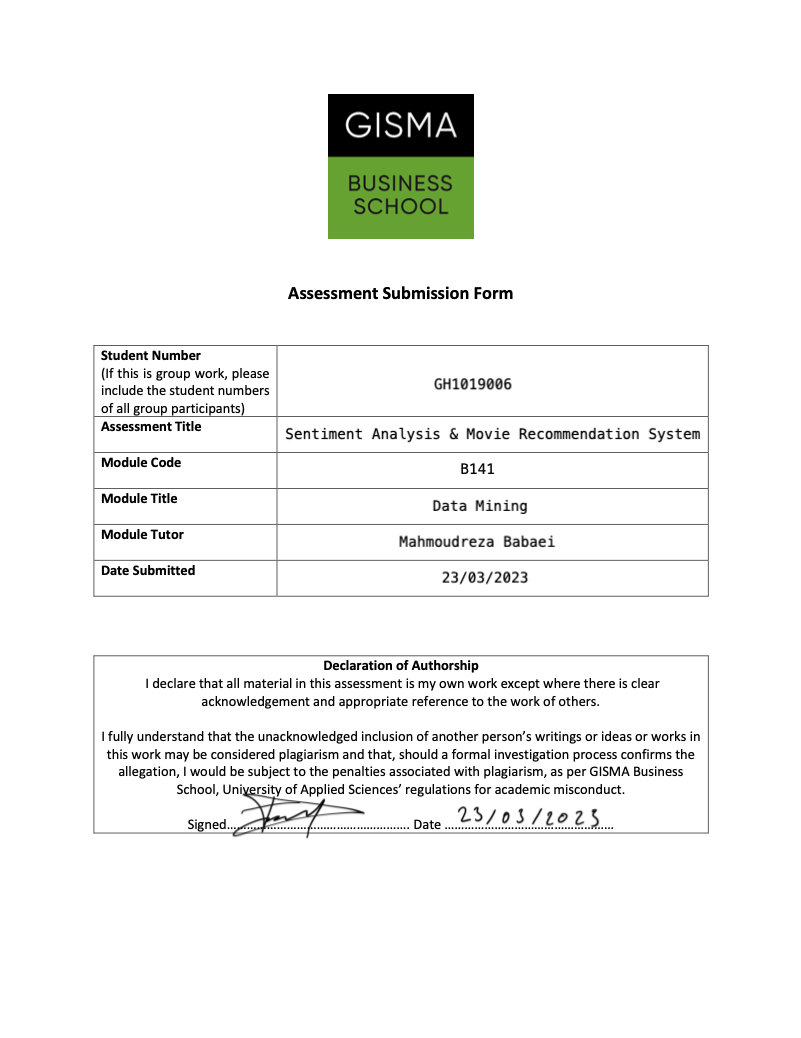

In [37]:
from IPython.display import Image

Image(filename='Data Mining Submission Form.png')